# **Define of Model**

In [1]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as n

In [2]:
def askey_wilson(n, x, a, b, c, d, q):
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return (2 * (1 + a * b * q) * x - (a + b) * (1 + c * d * q)) / (1 + a * b * c * d * q**2)
    else:
        An = (1 - a * b * q**(n-1)) * (1 - c * d * q**(n-1)) * (1 - a * b * c * d * q**(2*n-2))
        An /= (1 - a * b * c * d * q**(2*n-1)) * (1 - a * b * c * d * q**(2*n))
        Cn = (1 - q**n) * (1 - a * b * q**(n-1)) * (1 - c * d * q**(n-1)) * (1 - a * b * c * d * q**(2*n-2))
        Cn /= (1 - a * b * c * d * q**(2*n-2)) * (1 - a * b * c * d * q**(2*n-1))
        return ((2 * x - An) * askey_wilson(n-1, x, a, b, c, d, q) - Cn * askey_wilson(n-2, x, a, b, c, d, q)) / (1 - q**n)

class AskeyWilsonKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(AskeyWilsonKANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.degree = degree

        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))
        self.d = nn.Parameter(torch.randn(1))
        self.q = nn.Parameter(torch.randn(1))

        self.askey_wilson_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.askey_wilson_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def forward(self, x):
        # Compute the Askey-Wilson basis functions
        askey_wilson_basis = []
        for n in range(self.degree + 1):
            askey_wilson_basis.append(askey_wilson(n, x, self.a, self.b, self.c, self.d, self.q))
        askey_wilson_basis = torch.stack(askey_wilson_basis, dim=-1)  # shape = (batch_size, input_dim, degree + 1)

        # Compute the Askey-Wilson interpolation
        y = torch.einsum("bid,iod->bo", askey_wilson_basis, self.askey_wilson_coeffs)  # shape = (batch_size, output_dim)
        y = y.view(-1, self.output_dim)

        return y

class MNISTAskeyWilsonKAN(nn.Module):
    def __init__(self):
        super(MNISTAskeyWilsonKAN, self).__init__()
        self.trigkan1 = AskeyWilsonKANLayer(784, 32, 3)
        self.bn1 = nn.LayerNorm(32)
        self.trigkan2 = AskeyWilsonKANLayer(32, 32, 3)
        self.bn2 = nn.LayerNorm(32)
        self.trigkan3 = AskeyWilsonKANLayer(32, 10, 3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x=x.tanh()
        x = self.trigkan1(x)
        x = self.bn1(x)
        x = self.trigkan2(x)
        x = self.bn2(x)
        x = self.trigkan3(x)
        return x

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10



criterion = nn.CrossEntropyLoss()


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

# **Training of Model**

In [4]:
Model_Names=['AskeyWilson']
model0 = MNISTAskeyWilsonKAN().to(device)
models=[model0]
total_params = sum(p.numel() for p in model0.parameters() if p.requires_grad)
print(f"Total trainable parameters of {Model_Names[0]}: {total_params}")


Total trainable parameters of AskeyWilson: 105871


AskeyWilson, Epoch 1, Train Loss: 0.6085, Test Loss: 0.2335, Test Acc: 0.93
AskeyWilson, Epoch 2, Train Loss: 0.2042, Test Loss: 0.1593, Test Acc: 0.95
AskeyWilson, Epoch 3, Train Loss: 0.1442, Test Loss: 0.1394, Test Acc: 0.96
AskeyWilson, Epoch 4, Train Loss: 0.1152, Test Loss: 0.1317, Test Acc: 0.96
AskeyWilson, Epoch 5, Train Loss: 0.0987, Test Loss: 0.1045, Test Acc: 0.97
AskeyWilson, Epoch 6, Train Loss: 0.0859, Test Loss: 0.1361, Test Acc: 0.96
AskeyWilson, Epoch 7, Train Loss: 0.0744, Test Loss: 0.1061, Test Acc: 0.97
AskeyWilson, Epoch 8, Train Loss: 0.0645, Test Loss: 0.1159, Test Acc: 0.97
AskeyWilson, Epoch 9, Train Loss: 0.0608, Test Loss: 0.1127, Test Acc: 0.97
AskeyWilson, Epoch 10, Train Loss: 0.0509, Test Loss: 0.1121, Test Acc: 0.97
AskeyWilson, Epoch 11, Train Loss: 0.0462, Test Loss: 0.1296, Test Acc: 0.97
AskeyWilson, Epoch 12, Train Loss: 0.0423, Test Loss: 0.1287, Test Acc: 0.96
AskeyWilson, Epoch 13, Train Loss: 0.0358, Test Loss: 0.1177, Test Acc: 0.97
AskeyWil

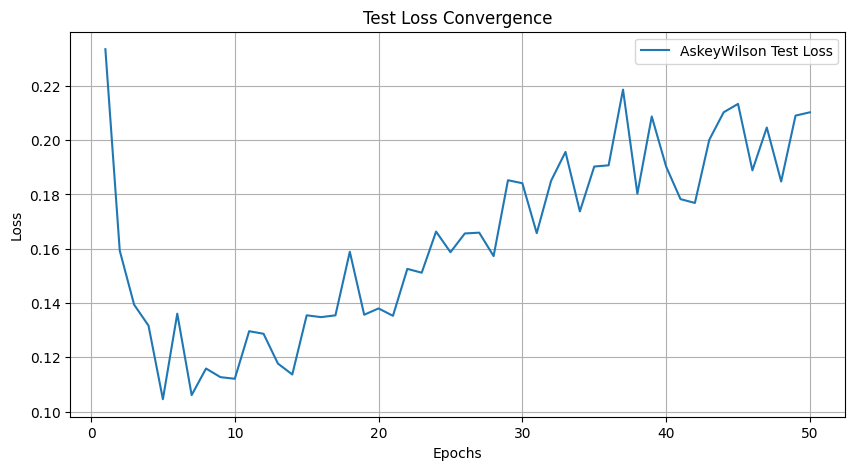

AskeyWilson processing time: 2418.00 seconds


In [5]:
import time

epochs = 50

def train_and_validate(models, model_names, train_loader, test_loader, criterion, optimizers, device, epochs):
    train_losses = [[] for _ in range(len(models))]
    test_losses = [[] for _ in range(len(models))]
    best_weights = [None] * len(models)
    best_test_losses = [float('inf')] * len(models)
    model_times = [0.0] * len(models)  # Initialize a list to store processing time for each model

    for epoch in range(epochs):
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            start_time = time.time()  # Record the start time

            train_loss = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_accuracy = validate(model, test_loader, criterion, device)

            end_time = time.time()  # Record the end time
            model_times[i] += end_time - start_time  # Accumulate the processing time for the current model

            train_losses[i].append(train_loss)
            test_losses[i].append(test_loss)

            if test_loss < best_test_losses[i]:
                best_test_losses[i] = test_loss
                best_weights[i] = model.state_dict()

            print(f'{model_names[i]}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

    return train_losses, test_losses, best_weights, model_times


optimizers = [optim.Adam(model.parameters(), lr=0.0002) for model in models]

train_losses, test_losses, best_weights, model_times = train_and_validate(models, Model_Names, train_loader, test_loader, criterion, optimizers, device, epochs)

plt.figure(figsize=(10, 5))
for i in range(len(models)):
    plt.plot(range(1, epochs + 1), test_losses[i], label=f'{Model_Names[i]} Test Loss')
plt.title('Test Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the best weights for each model
for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    torch.save(model.state_dict(), f'{Model_Names[i]}_best_weights.pth')

# Print the processing time for each model
for i, model_name in enumerate(Model_Names):
    print(f"{model_name} processing time: {model_times[i]:.2f} seconds")

# **Model Test**

In [6]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    test_labels=[]

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_labels.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
    return predictions,test_labels


In [7]:
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score
metrics = {
    'Accuracy': [],
    'Kappa': [],
    'F1 Score': []
}

for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    model.eval()

    test_preds,test_labels = predict(model, test_loader, device)
    f1 = f1_score(test_labels, test_preds, average='micro')
    kappa = cohen_kappa_score(test_labels, test_preds)
    overall_acc = accuracy_score(test_labels, test_preds)
    metrics['Accuracy'].append(overall_acc)
    metrics['Kappa'].append(kappa)
    metrics['F1 Score'].append(f1)
    
    print(f"Model {Model_Names[i]} - "
          f"Overall Accuracy: {overall_acc:.4f}, "
          f"Kappa: {kappa:.4f}, "
          f"F1 Score: {f1:.4f}")

Model AskeyWilson - Overall Accuracy: 0.9693, Kappa: 0.9659, F1 Score: 0.9693


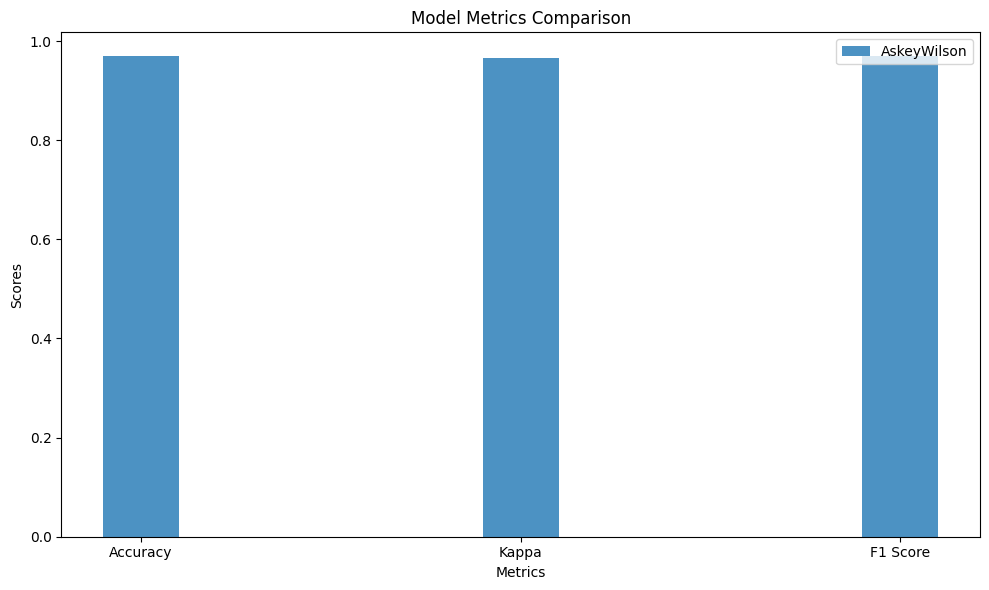

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics.keys()))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each model

for i, model_name in enumerate(Model_Names):
    model_metrics = [metrics['Accuracy'][i], metrics['Kappa'][i], metrics['F1 Score'][i]]
    ax.bar(index + i * bar_width, model_metrics, bar_width,
           alpha=opacity, color=colors[i], label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Metrics Comparison')
ax.set_xticks(index + bar_width * (len(Model_Names) - 1) / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()

TypeError: GridSpec.__init__() got an unexpected keyword argument 'ax'

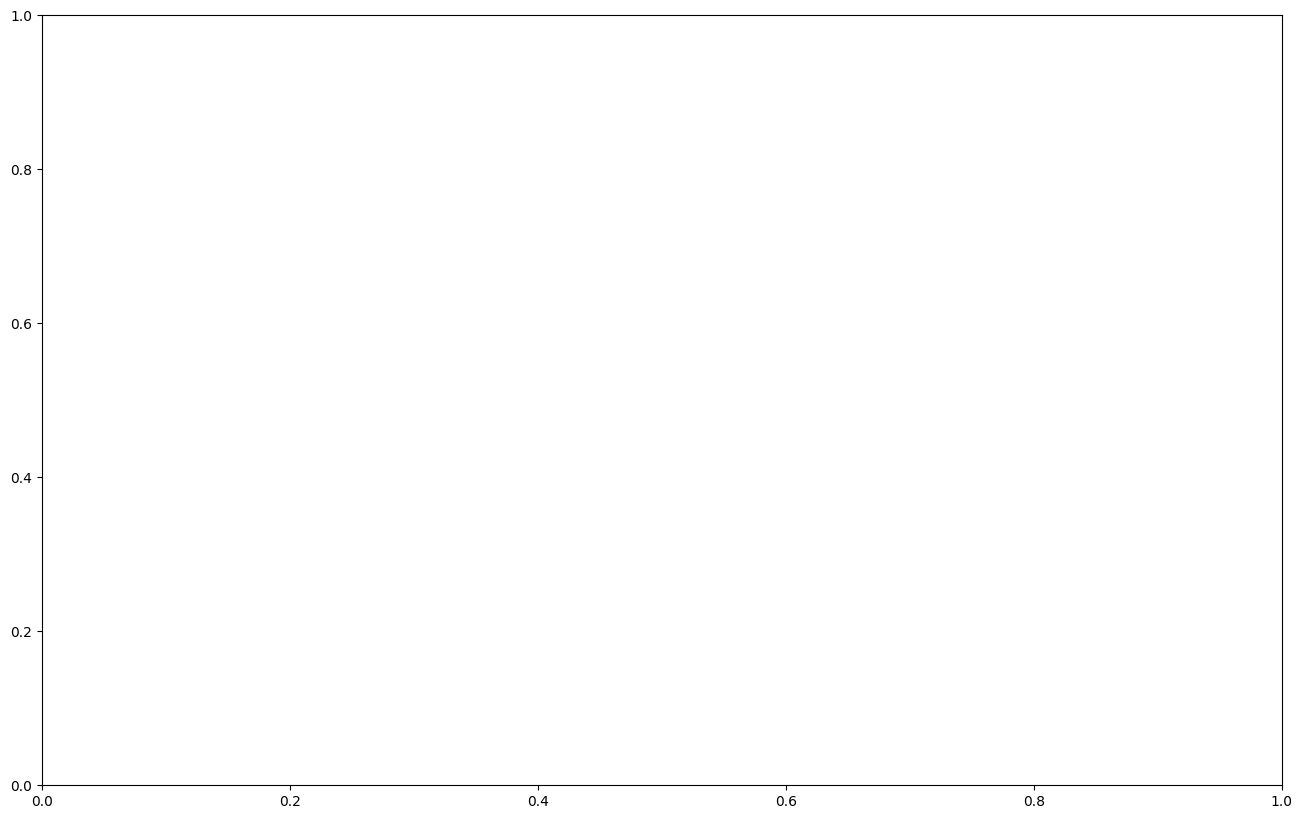

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from brokenaxes import brokenaxes

# Define the data
models = ['AlSalam', 'BannaiIto', 'Boas-Buck', 'Boubaker', 'Charlier', 'Gottlieb',
          'Heptanacci', 'Hexanacci', 'Meixner', 'Narayana', 'Octanacci', 'Pado',
          'Pentanacci', 'Tetranacci', 'Tribo', 'Vieta-Pell', 'Fermat', 'Askey']
num_params = [105862, 105865, 105880, 105856, 105856, 219907, 105856, 105856, 105862, 105856,
              105856, 105856, 105856, 105856, 105856, 105856, 105856, 105871]
training_time = [927.30, 1261.58, 1220.49, 807.36, 853.90, 923.96, 729.22, 760.49, 1095.85, 773.70,
                 770.62, 764.13, 762.46, 767.92, 751.97, 792.53, 757.21, 2418.00]
oa = [0.9675, 0.9670, 0.9663, 0.9731, 0.9726, 0.9759, 0.9426, 0.9641, 0.9703,
      0.9723, 0.9688, 0.9653, 0.9542, 0.9675, 0.9569, 0.9749, 0.9619, 0.9693]

# Create a figure and axis with broken axes
fig, ax = plt.subplots(figsize=(16, 10))
bax = brokenaxes(xlims=((104000, 105000), (220000, 222000)), ylims=((600, 1350), (2400, 2500)), hspace=0.05, wspace=0.05, d=0.01, ax=ax)

# Create a scatter plot
scatter = bax.scatter(num_params, training_time, s=np.array(oa) * 1500, c=oa, cmap='viridis', alpha=0.7, edgecolors='black', linewidths=1)

# Add labels and title
bax.set_xlabel('Number of Parameters', fontsize=18, weight='bold')
bax.set_ylabel('Training Time (s)', fontsize=18, weight='bold')
bax.set_title('Training Time vs. Number of Parameters', fontsize=22, weight='bold')

# Create a colorbar manually
cbar = fig.colorbar(scatter, ax=bax.axs[0], orientation='vertical')
cbar.set_label('Overall Accuracy', fontsize=16, weight='bold')
cbar.ax.tick_params(labelsize=14, which='major', width=2, length=6)

# Rotate the x-axis labels for better visibility
bax.set_xticklabels(bax.get_xticklabels(), rotation=45, ha='right', fontsize=14, weight='bold')
bax.set_yticklabels(bax.get_yticklabels(), fontsize=14, weight='bold')

# Add grid lines
bax.grid(linestyle='--', alpha=0.5, linewidth=1.5)

# Add text annotations for model names
for i, model in enumerate(models):
    bax.annotate(model, (num_params[i], training_time[i]), fontsize=12, ha='center', va='center', weight='bold')

# Adjust spacing and display the plot
fig.tight_layout()
plt.show()